# Preface

## **Title**  
*Prognostic Value of Baseline and Pre-Lymphodepletion PET/CT Imaging in DLBCL Patients Undergoing CAR T-Cell Therapy*

***

## Motivation

Chimeric Antigen Receptor (CAR) T-cell therapy has emerged as a transformative treatment modality for hematologic malignancies, demonstrating remarkable efficacy in diffuse large B-cell lymphoma (DLBCL) [1], [2], [3], [4], [5]. However, bridging therapy is frequently required to control disease burden during the manufacturing period before CAR T-cell infusion [1], [6], [7], [8], [9]. One way to measure the efficacy of bridging therapy on CAR T-cell therapy is through 18F-Fluorodeoxyglucose Positron Emission Tomography/Computerized Tomography (18F-FDG PET/CT) imaging. Current literature predominantly focuses on measuring conventional PET metrics such as metabolic active tumor volume (MATV) and standardized uptake value (SUVmax) at single timepoints, rather than employing comprehensive radiomic analysis of dynamic changes [10], [11], [12] . The prognostic value of high-dimensional radiomic features and their temporal evolution (delta radiomics) between baseline and pre-lymphodepletion chemotherapy (pre-LD) scans remains largely unexplored in the CAR T-cell therapy context [11].

***

## Strategic goals

We aim to assess whether baseline, pre-LD or delta radiomic profiles (extracted during the bridging period) provide superior prognostic value compared to conventional clinical variables for predicting treatment response, toxicity, progression-free survival, and overall survival.

***

## Starting point

Current literature predominantly focuses on conventional PET metrics such as metabolic active tumor volume (MATV) and standardized uptake value (SUVmax) at single timepoints, rather than employing comprehensive radiomic analysis of dynamic changes [13]. Preliminary evidence suggests reduced MATV prior to infusion correlates with improved OS (Overall Survival) and TTP (Time To Progression) [12], [14]. Few studies have systematically assessed delta radiomic features, and almost none have explored high-dimensional changes in a CAR T-cell cohort [13], [15]. Bridging strategies (systemic therapy, radiotherapy, or combinations) may influence imaging dynamics, but their detailed prognostic impact remains unclear [16], [17]. 

***

## Expected results (Hypothesis)

We hypothesize that comprehensive delta radiomic analysis will demonstrate enhanced prognostic capability compared to conventional single-timepoint metrics.

# Purpose of this notebook

During this course project, we worked on semi-manually segmenting the lesions using PET/CT scan images, with the help of the lesion report, created by radiologists, for each patient.

After this stage, we received the clinical data, which includes factors such as: age, gender, dates of important events, etc.

In the end, this notebook is dedicated to preprocessing, combining the radiomics data extracted from the images, and the clinical data, and then finally, running suitable analysis on them to test our hypothesis.

# Results
With 30 patients and 173 features, after correcting for multiple testing of the univariate cox regression:

**Overall Survival**   
**definition** Time from randomization/treatment start to death from any cause.[18]

after correcting for multiple analysis there were no significant features left. 
Before the correction, we could observe that radiomic features from a time point closer to the start of the CAR-T cell therapy showed significant Hazard Ratios.

**Progression Free Survival**   
**definition** The length of time during and after the treatment of a disease, such as cancer, that a patient lives with the disease but it does not get worse. In a clinical trial, measuring the progression-free survival is one way to see how well a new treatment works. Also called PFS.[18]

This analysis showed similar results to the Overall Survival.

However, we could produce hypotheses based on the Kaplan-Meier + log-rank test results. As we can see, features with the highest hazard ratio for OS/PFS show promise in discriminating patients with high and low risk.


# Delta Radiomics

In [1]:
import pandas as pd
import numpy as np
import yaml

with open('D:\\RadiomicsProject\\radiogit\\integromics\\mahsa\\config.yaml', 'r') as file:
    config = yaml.safe_load(file)
    radiomic_path = config['radiomic']
    clinical_data = config['clinical']

In [2]:
import os
import pandas as pd
from src import calculate_delta_radiomics

In [3]:
# Define the path to your main data folder
DATA_DIR = radiomic_path

# Run the function
delta_radiomics_results, a_radiomics, b_radiomics = calculate_delta_radiomics(DATA_DIR)

Delta radiomics calculation completed.


In [4]:
# Clean and prepare dataframes
# by dropping columns with any NaN values and resetting index
# to keep only the complete cases (some patients have 99 columns with NaNs, but 43 are always present)
# we'll work with those 43.
for df in [delta_radiomics_results, a_radiomics, b_radiomics]:
    df.dropna(axis=1, how='any', inplace=True)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'id'}, inplace=True)
    df['id'] = df['id'].astype(int)

In [5]:
# to differentiate the columns of A and B datasets
a_radiomics = a_radiomics.add_suffix('_a')

In [6]:
b_radiomics = b_radiomics.add_suffix('_b')

# Clinical Data

In [7]:
# read the clinica data
clinic_data= pd.read_excel(clinical_data)

In [8]:
clinic_data.shape

(69, 275)

# Data Preprocessing
This includes:  
* Joining the tables on patient ID to get both clinical and radiomics data
* Encoding and typecasting features
* Dropping features with zero variance and redundant features
* Imputing a few missing values


In [9]:
clinic_data['record_id'].values[:5]

array(['Record ID', 'FTC-UMCG-0001', 'FTC-UMCG-0002', 'FTC-UMCG-0003',
       'FTC-UMCG-0004'], dtype=object)

In [10]:
# create a new column with cleaned ids containing only the last 3 digits
clinic_data['id_cleaned'] = [value[-3:] for value in clinic_data['record_id'].values]

In [11]:
patient_ids = clinic_data['id_cleaned'].values[1:].astype(int)

In [12]:
# find patients that are in both datasets
# values starts from 1 to skip the comment row
intercept = [id for id in delta_radiomics_results['id'] if id in patient_ids]

In [13]:
clinic_data['id_cleaned'] = ['ID'] + patient_ids.tolist()

In [14]:
clinic_data_cleaned = clinic_data[clinic_data['id_cleaned'].isin(intercept)]

In [15]:
clinic_data_cleaned.reset_index(drop=True, inplace=True)

In [16]:
clinic_data_cleaned.shape

(30, 276)

In [17]:
deaths = clinic_data_cleaned['surv_status.factor']

Eventually, we have 24 patients with complete clinical and delta radiomics data to work with.

**Note:** patient 95 is missing their clinical data. 

we now should select features we need for modelling the baseline, without the delta radiomics

In [18]:
# dropping columns with all NaN values
clinic_data_cleaned = clinic_data_cleaned.dropna(axis=1, how='all')

In [19]:
clinic_data_cleaned.shape

(30, 266)

In [20]:
# we don't need factor columns for modelling as they are encoded already
# we need to exclude the 'surv_death_cause.factor' column as it is important for our event indicator for time to progression analysis
factors = [factor for factor in clinic_data_cleaned.columns if 'factor' in factor]

In [21]:
comments = [comm for comm in clinic_data_cleaned.columns if 'comment' in comm]

In [22]:
locations = [loc for loc in clinic_data_cleaned.columns if 'loc' in loc]

In [23]:
# these are highly correlated features with bmi
correlated = ['scr_height', 'scr_weight']

* scr_age (continuous) correlates to indication_age_60 (binary), we Keep scr_age (continuous). It retains more information and doesn't arbitrarily cut at 60.  
* indication_ldh_uln: we have the exact value for ldh  
* indication_extran_sites, indication_extran_invol, indication_extranodal_nr	These are highly related. we keep indication_extranodal_nr (exact number). It is the most granular quantitative measure.

In [24]:
indicators = ['indication_ldh_uln','indication_age_60','indication_extran_sites', 'indication_extran_invol']

In [25]:
# cause of death columns are not needed
cause_of_death = [cause for cause in clinic_data_cleaned.columns if '_cause' in cause]

**NOTE:** indication_dis_diagnosis must be one-hot encoded. as the disease is a nominal categorical feature.

In [26]:
disease = pd.get_dummies(clinic_data_cleaned['indication_dis_diagnosis.factor']).astype(int)

In [27]:
drop_columns = cause_of_death + factors + ['record_id','scr_date_tb1stmeeting', 'indication_dis_diagnosis'] + comments + locations + correlated + indicators
clinic_data_cleaned.drop(columns=drop_columns,inplace=True)

In [28]:
clinic_data_cleaned.shape

(30, 97)

In [29]:
clinic_data_cleaned = pd.concat([clinic_data_cleaned, disease], axis=1)

In [30]:
clinic_data_cleaned.replace({'NE': np.nan}, inplace=True)

C:\Users\zfvah\AppData\Local\Temp\ipykernel_23704\3391465230.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clinic_data_cleaned.replace({'NE': np.nan}, inplace=True)


In [31]:
nans = clinic_data_cleaned.isna().sum().sort_values(ascending=False)

In [32]:
nans

indication_dis_lymsubtype_cns_onset    29
post_car_ther_other                    29
surv_death_contrib_infect              29
surv_death_contrib_other               29
tr_car_preaph_bridg_type               28
                                       ..
id_cleaned                              0
DLBCL                                   0
HGBCL DH/TH                             0
HGBCL NOS                               0
tFL                                     0
Length: 101, dtype: int64

In [33]:
# columns with more than half of the data missing for the patients we have
# but we are careful with date related columns for later analysis, 
# as for example surv_prog_date could be missing for patients who have not yet progressed
# or surv_death_date could be missing for patients who are still alive
nans[nans > clinic_data_cleaned.shape[0]/2]

indication_dis_lymsubtype_cns_onset    29
post_car_ther_other                    29
surv_death_contrib_infect              29
surv_death_contrib_other               29
tr_car_preaph_bridg_type               28
tr_car_bridg_reg_oth                   28
indication_extranodal_nr               23
total_num_priortherapylines_fl         18
ae_summ_crs_start_gr2                  18
post_cart_ther_startdate               17
ae_summ_icans_start_gr2                16
dtype: int64

In [34]:
# droping columns with more than half nans
drop_nans = nans[nans > clinic_data_cleaned.shape[0]/2].index

In [35]:
clinic_data_cleaned = clinic_data_cleaned.drop(columns=drop_nans)

In [36]:
clinic_data_cleaned.shape

(30, 90)

In [37]:
date_columns = [date for date in clinic_data_cleaned.columns if ('date' in date) or ('start' in date) or ('stop' in date)]

print("Applying type conversion...")
for col in clinic_data_cleaned.columns:
        if col not in date_columns:
            # Attempt to convert to numeric.
            # and fix a typo in columns where , is used instead of .
            if clinic_data_cleaned[col].dtype == 'object':
                clinic_data_cleaned[col] = pd.to_numeric(clinic_data_cleaned[col].str.replace(',','.'), errors='raise')
            # print(f"  Converted column '{col}' to numeric.")
        else: 
            clinic_data_cleaned[col] = pd.to_datetime(clinic_data_cleaned[col], errors='coerce')
            # print(f"  Converted column '{col}' to datetime.")
        
print("\nAutomatic type conversion complete.")

Applying type conversion...

Automatic type conversion complete.


In [38]:
variances = clinic_data_cleaned.select_dtypes(include=np.number).var().sort_values()

In [39]:
# zero variance columns are not useful for modelling so I am dropping them
zero_var = variances[variances == 0].index

In [40]:
clinic_data_cleaned = clinic_data_cleaned.drop(columns=zero_var)

In [41]:
clinic_data_cleaned.shape

(30, 60)

In [42]:
# Impute missing values with the median for numeric columns
for col in clinic_data_cleaned.select_dtypes(include=np.number).columns:
    median_value = clinic_data_cleaned[col].median()
    clinic_data_cleaned[col].fillna(median_value, inplace=True)

C:\Users\zfvah\AppData\Local\Temp\ipykernel_23704\2647843388.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clinic_data_cleaned[col].fillna(median_value, inplace=True)


In [43]:
# there are date related column that still have nans, but we will not use them for modelling as we can't impute them easily
# also cli_st_lab_date is not needed
# we need to keep surv_prog_date for time to progression analysis so we're not dropping it here
date_columns = ['ae_summ_icans_stop_v2','ae_summ_icans_start_v2', 
                # 'surv_prog_date',
                'surv_death_date', 
                'ae_summ_crs_start_v2',
                'ae_summ_crs_stop_v2',
                'cli_st_lab_date']
clinic_data_cleaned = clinic_data_cleaned.drop(columns=date_columns)

In [44]:
clinic_data_cleaned.shape

(30, 54)

# Cox Regression model
we will use the CoxPHFitter class from the lifelines library.

In [45]:
# pip install lifelines

In [46]:
from lifelines import CoxPHFitter

## Model Fitting 
We're going to use cox regression to perform a univariate analysis on the radiomic features

In [47]:
from src import cox_univariate_analysis


**Result meaning:**

Hazard Ratio (HR): >1 indicates increased hazard (worse survival); <1 means decreased hazard (better survival).

P-value: significance of association (commonly <0.05 is considered significant).

Confidence interval: range of plausible values for HR.

**How to Interpret the HR**

HR = 1: No effect. The risk in both groups (or levels) is the same.

HR > 1: Increased hazard (risk). The event is more likely in the group coded "1" or for higher values of the variable. For example, HR = 1.5 means a 50% higher risk.​

HR < 1: Decreased hazard (risk). The event is less likely in the group coded "1" or for higher values of the variable. For example, HR = 0.7 means a 30% lower risk.


## What Is the Hazard?

- **The hazard rate** is the *instantaneous risk* of the event (like death) happening **at a particular time**, *given that the person has survived up until that time*.
    - In formulas: 
     h(t) = chance event(e.g. death) occurs right after time *t* / chance survived up to time *t*.
    - It is measured *per unit time* (e.g., per month or per year).

Think of it as **the event rate among those still at risk**, *right now*.

- For each group (treatment vs control), you can estimate the hazard rate over time.

In Cox regression, the hazard ratio (HR) describes how the hazard—the instantaneous rate of the event occurring—changes with a one-unit increase in a given feature, assuming all other variables are held constant
***

## What Does the Hazard Ratio (HR) Tell You?

- The **hazard ratio** compares the *hazard rates* between two groups:
    - HR = hazard in group 1 / hazard in group 0.
- For example, if HR = 2:
    - The event (death) happens **twice as quickly** (per unit time) in treatment as in control.
- If HR = 0.5:
    - The event happens **half as quickly** in the group coded as 1(treatment) compared to the group coded as 0(control).

***
## Continuous Feature in Cox Regression, Hazard for continuous features
Example:
Suppose age is your feature, and your model estimates β=0.04
Then, HR=exp(0.04)≈1.04
HR=exp(0.04)≈1.04.

Interpretation: Each additional year of age is associated with a 4% higher hazard (risk of event, e.g., death).

When you have a continuous variable (like albumin level), the Cox regression estimates the effect per unit increase in that variable:

The hazard ratio (HR) is calculated as exp(β), where β is the regression coefficient.
If β<0, then exp(β) falls between 0 and 1.​

What does HR < 1 mean for a continuous variable?
An HR < 1 means that as the value of your variable increases, the hazard (risk) of the event decreases.

For every one unit increase (e.g., each point higher albumin), the risk of the event happening goes down by a factor of the hazard ratio.

## Key Points to Remember

- Hazard ≠ cumulative risk. The *hazard* is about the **rate at which events are happening at a specific instant**.
- **Kaplan–Meier curves** can show the cumulative risk (probability) but the hazard is about the *slope* or how quickly the curve drops.
- Cox regression estimates how covariates (like treatment) influence this rate, assuming the ratio (HR) is the same at all times (*proportional hazards*).

***

# Overall Survival
According to the National Cancer Institute: The length of time from either the date of diagnosis or the start of treatment for a disease, such as cancer, that patients diagnosed with the disease are still alive. In a clinical trial, measuring the overall survival is one way to see how well a new treatment works. Also called OS [19]

## Calculate Time-to-Event for Overall Survival

We need to select one pair of dates to calculate the duration of follow-up (Time, or $T$).  
Choice: The standard time point for post-therapy outcomes is from the date of infusion to the date of follow-up/death.  
Start Date: tr_car_inf_date (Date of CAR-T infusion)  
End Date: surv_date (Date of last follow-up or death)  

In [48]:
# Calculate the Time-to-Event (T) in days
# This is the time from infusion until the event (or censoring)
# This would be analyzing for the overall survival (OS)
clinic_data_cleaned['T'] = (
    clinic_data_cleaned['surv_date'] - clinic_data_cleaned['tr_car_inf_date']
).dt.days

## Define the Event Indicator for Overall Survival (OS)

We need a binary variable (Event, or $E$) that indicates if the event of interest occurred.Choice: The most common target is OS, where the event is death.Event Variable: surv_status (Assuming this is a 0/1 indicator where 1 = death/event)

In [49]:
# in the dataset, it's the opposite of what we want: 1 means event occurred (death), 0 means censored (alive)
# so we need to invert it
clinic_data_cleaned['surv_status'] = 1 - clinic_data_cleaned['surv_status']

In [50]:
# rename surv_status to E for event
clinic_data_cleaned.rename(columns={'surv_status': 'E'}, inplace=True)

In [51]:
# we should separate the possible target variables for modelling now
target_variables = ['surv_time_bestresponse_car', 'surv_prog_after_car']
date_related = ['tr_car_inf_adm_date','tr_car_ld_start', 'tr_car_inf_date', 'tr_car_inf_discharge_date',
       'ae_summ_start_date_v2','surv_date','indication_ind_date','surv_prog_date']

In [52]:
modelling_data = pd.concat([clinic_data_cleaned, delta_radiomics_results, a_radiomics, b_radiomics], axis=1)

In [53]:
modelling_data.shape

(31, 187)

In [54]:
# we need to drop the last row, as the patient's clinical data is not available
modelling_data = modelling_data.iloc[:-1,:]

In [55]:
# to find the baseline performance, we don't need id_cleaned as we're not going to
# use this column for adding the delta radiomics yet
modelling_data_os = modelling_data.drop(columns=target_variables + date_related + ['id_a','id_b','id_cleaned','id'])                    

In [56]:
modelling_data_os.shape

(30, 173)

In [57]:
results_df = cox_univariate_analysis(modelling_data_os)
results_df[results_df['p_value'] < 0.05].sort_values('p_value')

Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.


,feature,HR,p_value,lower_CI,upper_CI,z_score
97,SUV_Range_b,2.587138,0.000911,1.475229,4.537114,3.316572
92,SUV_Maximum_b,2.520694,0.001056,1.449588,4.383243,3.275261
96,SUV_Peak_b,2.668759,0.001525,1.454534,4.896602,3.169945
89,SUV_Energy_b,1.703975,0.017899,1.096125,2.648904,2.367705
102,SUV_TotalEnergy_b,1.659200,0.021483,1.077607,2.554685,2.299387
86,SphericalDisproportion_b,1.525399,0.026606,1.050219,2.215578,2.217252
53,SphericalDisproportion_a,1.541233,0.027177,1.049970,2.262349,2.208964
54,SurfaceArea_a,1.539955,0.036894,1.026616,2.309980,2.086934
46,LeastAxisLength_a,1.749861,0.046718,1.008159,3.037234,1.988848


With very large values, the unscaled HR per unit is minuscule (e.g., 1.000001), making interpretation unintuitive despite significance. That's why we did the feature Standardization; to yield an HR per 1-SD increase, which is clinically meaningful and comparable across models or variables (e.g., "HR=1.7 per SD SUV_TotalEnergy_b"). 

**NOTE:** The order would NOT change, as it's just a simple scaling, done for every feature

Because we test many features (when running many univariable Cox regressions on radiomic features), we should adjust p-values (e.g., Benjamini-Hochberg/FDR) to avoid false positives. As testing many features increases the chance of finding significant results just by chance (false positives). Multiple testing correction helps control this.

In [58]:
import statsmodels.stats.multitest as smm

pvals = results_df['p_value'].values  # your list of p-values
rejected, pvals_corrected, _, _ = smm.multipletests(pvals, alpha=0.05, method='bonferroni')

# rejected gives True/False for significance at FDR 0.05
# pvals_corrected gives the adjusted p-values


In [59]:
# no significant features after correction
pvals_corrected[pvals_corrected < 0.05]

array([], dtype=float64)

# Progression Free Survival

According to the National Cancer Institute Progression Free Survival is the length of time during and after the treatment of a disease, such as cancer, that a patient lives with the disease but it does not get worse. In a clinical trial, measuring the progression-free survival is one way to see how well a new treatment works. Also called PFS [20].


## Define the Event and Time-to-Event for Progression Free Survival

Progression-free survival (PFS) measures the time from treatment start (e.g., CAR T infusion) to disease progression or death from any cause, whichever occurs first. [19]

In [60]:
pfs_time = []
pfs_status = []
for i in range(clinic_data_cleaned.shape[0]):
    if deaths.iloc[i] == 'Dead':
        pfs_status.append(1)
    if deaths.iloc[i] == 'Alive':
        pfs_status.append(0)
    if clinic_data_cleaned['surv_prog_date'].iloc[i] is not pd.NaT:
        pfs_time.append((clinic_data_cleaned['surv_prog_date'].iloc[i] - clinic_data_cleaned['tr_car_inf_date'].iloc[i]).days)
    else:
        pfs_time.append((clinic_data_cleaned['surv_date'].iloc[i] - clinic_data_cleaned['tr_car_inf_date'].iloc[i]).days)


In [61]:
clinic_data_cleaned['PFS'] = pfs_time
clinic_data_cleaned['PFS_status'] = pfs_status

In [62]:
# columns that we don't need for modelling
target_variables = ['surv_time_bestresponse_car', 'surv_prog_after_car','E']
date_related = ['tr_car_inf_adm_date','tr_car_ld_start', 'tr_car_inf_date', 'tr_car_inf_discharge_date',
       'ae_summ_start_date_v2','surv_date','indication_ind_date','surv_prog_date','T']

In [63]:
modelling_data_pfs = pd.concat([clinic_data_cleaned, delta_radiomics_results, a_radiomics, b_radiomics], axis=1)
modelling_data_pfs.drop(columns=target_variables + date_related + ['id_a','id_b','id_cleaned','id'], inplace=True)
modelling_data_pfs = modelling_data_pfs.iloc[:-1,:]

In [64]:
modelling_data_pfs.isna().sum().sum()

np.int64(0)

In [65]:
modelling_data_pfs.shape

(30, 173)

In [66]:
results_df_pfs = cox_univariate_analysis(modelling_data_pfs, T_col='PFS', E_col='PFS_status')

Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.


In [67]:
results_df_pfs

,feature,HR,p_value,lower_CI,upper_CI,z_score
0,scr_age,0.987286,0.956421,0.623913,1.562290,-0.054646
1,scr_bmi,1.018371,0.942385,0.621585,1.668443,0.072273
2,indication_stage,1.154032,0.577259,0.697334,1.909830,0.557392
3,indication_res_last_ther_spec,0.899673,0.632334,0.583432,1.387327,-0.478444
4,cli_st_trombocytes,1.493690,0.183278,0.827182,2.697241,1.330729
...,...,...,...,...,...,...
105,Number of lesions_b,1.409023,0.096990,0.939833,2.112443,1.659626
106,Dmax Patient (mm)_b,1.124452,0.633794,0.694002,1.821886,0.476394
107,Spread Patient (mm)_b,1.283830,0.204306,0.872907,1.888196,1.269379
108,Dmax Bulk (mm)_b,1.014380,0.951433,0.640717,1.605961,0.060907


In [68]:
results_df_pfs[results_df_pfs['p_value'] < 0.05].sort_values('p_value')

,feature,HR,p_value,lower_CI,upper_CI,z_score
96,SUV_Peak_b,2.089525,0.010396,1.189167,3.671575,2.562376
97,SUV_Range_b,1.969021,0.010816,1.169396,3.315424,2.548602
92,SUV_Maximum_b,1.936005,0.011961,1.156553,3.240764,2.513294
89,SUV_Energy_b,1.639839,0.029664,1.050018,2.560977,2.174550
102,SUV_TotalEnergy_b,1.595129,0.035689,1.031725,2.466197,2.100451


In [69]:
# adjusting p-values for multiple testing
pvals = results_df_pfs['p_value'].values  # your list of p-values
rejected, pvals_corrected, _, _ = smm.multipletests(pvals, alpha=0.05, method='bonferroni')

In [70]:
pvals_corrected[pvals_corrected < 0.05]

array([], dtype=float64)

# Kaplan-Meier Curve

Kaplan-Meier (K-M) curves estimate and visualize survival probabilities over time from censored event data, such as PFS or OS in oncology trials. [21,22]


## What the plot shows

- The **horizontal axis** represents time (e.g., months, years).
- The **vertical axis** shows the estimated probability of survival or event-free status — starting at 1 (100%) at time zero and decreasing over time.


## How to interpret the curve

- Each **downward step** occurs when an event (e.g., death, relapse) happens, reflecting a drop in survival probability.
- **Horizontal plateaus** indicate periods with no events, where survival is stable.
- The **steepness** of the slope matters: a steeper downward step means a higher event rate (worse survival); a flatter curve means better survival.


## Understanding survival probabilities

- At any time point on the curve, the vertical value is the estimated probability of still surviving beyond that time.
- For example, if at 12 months the curve is at 0.85, it means an estimated 85% of subjects survive at least 12 months, or 15% have experienced the event by then.


## How each drop is calculated

For each distinct event time \(t\):

1. Let \(n_t\) be the number of patients “at risk” just before time \(t\) (alive patients).  
2. Let \(d_t\) be the number of deaths at time \(t\).  
3. The conditional survival at that time is  
   $$
   1 - \frac{d_t}{n_t}
   $$  
4. The KM survival estimate after that time is the product of all previous conditional survivals:  
   $$
   \hat S(t) = \prod_{u \le t} \left(1 - \frac{d_u}{n_u}\right)
   $$

So the size of each vertical drop equals multiplying the previous survival probability by \(1 - d_t/n_t\); more deaths or fewer patients at risk at that time produce a larger visible drop. Censored patients (those lost to follow‑up or still alive at last contact) simply reduce the future risk set at the time they are censored and do not cause any drop in the curve. [21,22]


## Additional details

- **Censoring** is shown by tick marks on the plot; those subjects were lost or event-free at last follow-up.
- Comparing two or more groups' curves helps to visualize differences in survival between treatments or populations, often supplemented by statistical tests.
- The curve is a step function estimating the survival function over time, useful for medical or reliability studies, among others.

This visualization helps understand how quickly events occur over time and estimate median survival times or probabilities at specific time points.


# What does the Log-rank test means?
Log-rank test is a Non-parametric hypothesis test comparing survival distributions across groups by calculating observed vs expected events at each time point, yielding a chi-squared statistic.
​
The log-rank test tests the null hypothesis of no difference between survival curves, based on event times. At each event time, it computes observed (O) deaths per group vs expected (E) under identical distributions, then sums (O-E)²/E across times for a χ² statistic (df = groups-1).

   The Null Hypothesis ($H_0$): There is no difference between the populations; any observed difference in survival is due to chance.  
   The Alternative Hypothesis ($H_1$): There is a significant difference between the groups' survival.T
   
the p-value: A p-value less than 0.05 indicates that you can reject the null hypothesis, meaning the feature effectively separates patients into different risk categories.

Essentially, the Log-rank test tells you if the separation shown on your KM curve is statistically reliable.

Here we have chosen to separate the patients based on the median values of the feature as it's an objective/pre-specified cutoff, standard practice avoiding data-driven bias. Equal sample sizes (~50% patients per group (high/low)), stabilizes log-rank power in small cohorts (n<100) [23].



# HR and KM/log-rank answer **different but complementary** questions

- **HR (from Cox)**: “How much does the instantaneous risk change per 1‑unit (or 1‑SD) increase in the feature, assuming proportional hazards?”  
- **KM + log-rank**: “If we split patients into high vs low (or other groups) based on that feature, do their **survival curves** actually separate over time, and is that difference statistically significant?”

So after you have HRs, you use **KM + log-rank** mainly for:

1. **Visualizing the effect**  
   - HR is abstract; clinicians want to see curves.  
   - KM shows curves which is much more interpretable than “HR=2.3”.

2. **Checking that the effect is clinically meaningful**  
   - A statistically significant HR might correspond to only a tiny difference in the curves.  
   - KM lets you see whether the separation is large enough to matter.

3. **Summarizing the effect as *risk groups***  
   - The Cox model uses the continuous feature.  
   - KM/log-rank turn that into a simple “high‑risk vs low‑risk” categorization (e.g. median split) that is easy to discuss and plot.

4. **Providing a second, non-parametric test**  
   - Cox assumes proportional hazards and models a linear effect of the feature.  
   - Log-rank is non-parametric (for the grouped version of the feature) and tests whether the whole survival distributions differ between groups.  

So the logic is:

- **First**: Cox HR per 1‑SD (effect size and CI).  
- **Then**: KM + log-rank on a simple split (e.g. median) to show “this feature defines a high‑risk group with visibly worse survival and a significant log-rank p‑value”.

**NOTE:** log-rank only provides p-values,  because it's a hypothesis test designed to answer a yes/no question: "Is there a statistically significant difference between the survival distributions of two or more groups?


In [71]:
from src import plot_stratified_km

# KaplanMeier(OS)


The median survival time is the smallest time $t$ at which the survival probability $S(t)$ is less than or equal to 0.5. If more than 50% of the patients in a specific group are still alive or progression-free at the time of their last follow-up, the Kaplan-Meier curve stays above the 0.5 line. Mathematically, the point where it hits 50% hasn't happened yet, so the value is reported as inf.

**an output of inf (infinity) for the median survival time occurs because the survival curve never reaches or drops below the 0.5 (50%) threshold within our observation period.**


High SUV_Range_b (>21.88) Median OS: 368.0 days
95% CI: 82.0 - 1142.0 days

Low SUV_Range_b (≤21.88) Median OS: inf days
95% CI: 327.0 - inf days


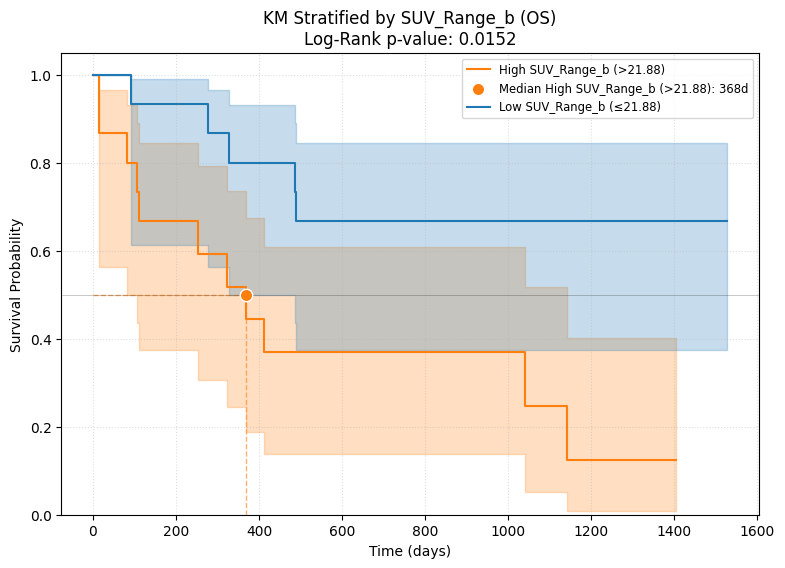

In [72]:
# Using the top HR feature from the univariate analysis to see stratified KM plots

# For Overall Survival (OS)
plot_stratified_km(modelling_data_os, 'T', 'E', 'SUV_Range_b', "OS")

# KaplanMeier(PFS)

The results indicates that based on the events that **did** occur, the statistical model can estimate with 95% confidence that the median survival is at least 56 days. However, because the survival rate remained high throughout the rest of the study, there is no data to determine an upper limit for when that 50% threshold might eventually be reached for the low risk group.


High SUV_Peak_b (>20.72) Median PFS: 186.0 days
95% CI: 56.0 - 775.0 days

Low SUV_Peak_b (≤20.72) Median PFS: inf days
95% CI: 56.0 - inf days


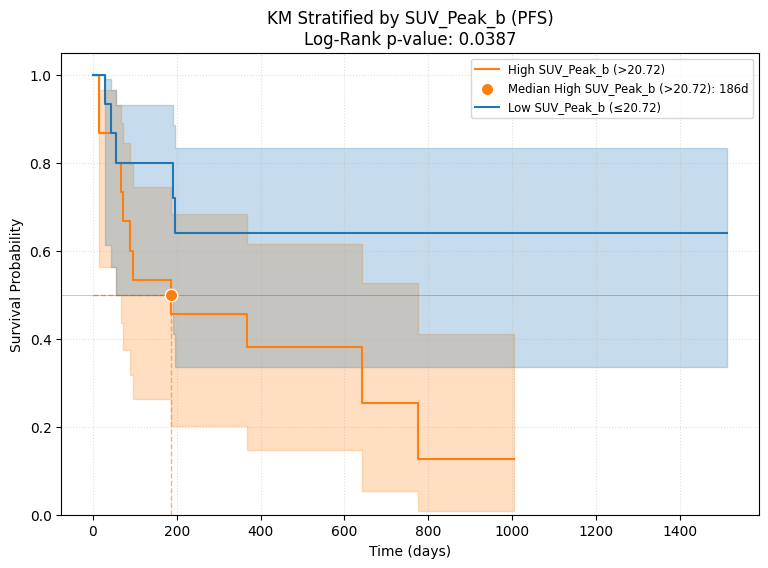

In [73]:
# For Progression-Free Survival (PFS)
plot_stratified_km(modelling_data_pfs, 'PFS', 'PFS_status', 'SUV_Peak_b', "PFS")

# OS/PFS overall median

inf means the upper bound never reached 50%

--- OS Summary ---
Median Survival: 1041.0 days
95% CI: 323.0 - inf days



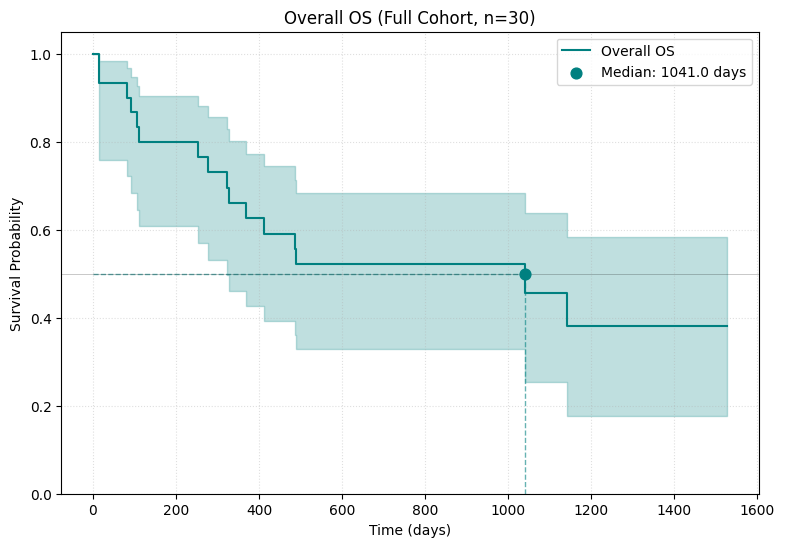

<lifelines.KaplanMeierFitter:"Overall OS", fitted with 30 total observations, 14 right-censored observations>

In [74]:
from src import plot_overall_km
# For Overall Survival
plot_overall_km(modelling_data_os, 'T', 'E', "OS")


--- PFS Summary ---
Median Survival: 643.0 days
95% CI: 96.0 - inf days



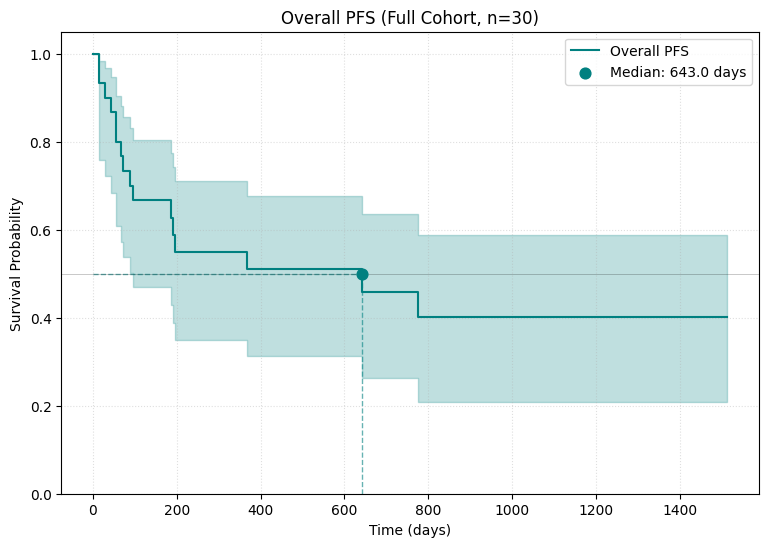

<lifelines.KaplanMeierFitter:"Overall PFS", fitted with 30 total observations, 14 right-censored observations>

In [75]:

# For Progression-Free Survival
plot_overall_km(modelling_data_pfs, 'PFS', 'PFS_status', "PFS")


## References
[1]	D. Mannina et al., “Role of bridging RT in relapsed/refractory diffuse large B-cell lymphoma undergoing CAR-T therapy: a multicenter study,” Nov. 20, 2023, In Review. doi: 10.21203/rs.3.rs-3573162/v1.

[2]	E. Laverdure et al., “Enhancing CAR-T Efficacy in Large B-Cell Lymphoma with Radiation Bridging Therapy: A Real-World Single-Center Experience,” Curr. Oncol., vol. 32, no. 3, p. 173, Mar. 2025, doi: 10.3390/curroncol32030173.

[3]	J. R. Westin et al., “Survival with Axicabtagene Ciloleucel in Large B-Cell Lymphoma,” N. Engl. J. Med., vol. 389, no. 2, pp. 148–157, July 2023, doi: 10.1056/NEJMoa2301665.

[4]	M. Crump et al., “Outcomes in refractory diffuse large B-cell lymphoma: results from the international SCHOLAR-1 study,” Blood, vol. 130, no. 16, pp. 1800–1808, Oct. 2017, doi: 10.1182/blood-2017-03-769620.

[5]	F. L. Locke et al., “Long-term safety and activity of axicabtagene ciloleucel in refractory large B-cell lymphoma (ZUMA-1): a single-arm, multicentre, phase 1–2 trial,” Lancet Oncol., vol. 20, no. 1, pp. 31–42, Jan. 2019, doi: 10.1016/S1470-2045(18)30864-7.

[6]	A. Kuhnl et al., “Outcome and feasibility of radiotherapy bridging in large B‐cell lymphoma patients receiving CD19 CAR T in the UK,” Br. J. Haematol., vol. 205, no. 2, pp. 483–494, Aug. 2024, doi: 10.1111/bjh.19453.

[7]	C. Ladbury et al., “Long-Term Follow-Up of Bridging Therapies Prior to CAR T-Cell Therapy for Relapsed/Refractory Large B Cell Lymphoma,” Cancers, vol. 15, no. 6, p. 1747, Mar. 2023, doi: 10.3390/cancers15061747.

[8]	T. Van Meerten, “Impact of debulking therapy on the clinical outcomes of axicabtagene ciloleucel in the treatment of relapsed or refractory large B-cell lymphoma,” Am. J. Cancer Res., vol. 14, no. 6, pp. 2905–2920, 2024, doi: 10.62347/LLXR8002.

[9]	C. Roddie et al., “Effective bridging therapy can improve CD19 CAR-T outcomes while maintaining safety in patients with large B-cell lymphoma,” Blood Adv., vol. 7, no. 12, pp. 2872–2883, June 2023, doi: 10.1182/bloodadvances.2022009019.

[10]	H. Ababneh, M. Bobić, J. Pursley, and C. Patel, “On Route to Chimeric Antigen Receptor T-cell (CAR T) Therapy, Less Is More: Adaptive Bridging Radiotherapy in Large B-cell Lymphoma,” Cureus, Aug. 2024, doi: 10.7759/cureus.67572.

[11]	Z. Sun and M. Liu, “Systematic review and meta-analysis of the association between bridging therapy and outcomes of chimeric antigen receptor T cell therapy in patients with large B cell lymphoma,” Cytotherapy, vol. 24, no. 9, pp. 940–953, Sept. 2022, doi: 10.1016/j.jcyt.2022.03.009.

[12]	K. Keijzer et al., “Reducing and controlling metabolic active tumor volume prior to CAR T-cell infusion can improve survival outcomes in patients with large B-cell lymphoma,” Blood Cancer J., vol. 14, no. 1, p. 41, Mar. 2024, doi: 10.1038/s41408-024-01022-w.

[13]	M. Ligero et al., “PET‐based radiomics signature can predict durable responses to CAR T‐cell therapy in patients with large B‐cell lymphoma,” eJHaem, vol. 4, no. 4, pp. 1081–1088, Nov. 2023, doi: 10.1002/jha2.757.

[14]	D. Leithner et al., “Conventional and novel [18F]FDG PET/CT features as predictors of CAR-T cell therapy outcome in large B-cell lymphoma,” J. Hematol. Oncol.J Hematol Oncol, vol. 17, no. 1, p. 21, Apr. 2024, doi: 10.1186/s13045-024-01540-x.

[15]	Y. Balagurunathan, J. W. Choi, Z. Thompson, M. Jain, and F. L. Locke, “Radiomic Features Prognosticate Treatment Response in CAR-T Cell Therapy,” Cancers, vol. 17, no. 11, p. 1832, May 2025, doi: 10.3390/cancers17111832.

[16]	J. Fan et al., “Potential synergy between radiotherapy and CAR T-cells - a multicentric analysis of the role of radiotherapy in the combination of CAR T cell therapy,” Radiother. Oncol., vol. 183, p. 109580, June 2023, doi: 10.1016/j.radonc.2023.109580.

[17]	C. Ladbury et al., “Prognostic significance of fludeoxyglucose positron emission tomography delta radiomics following bridging therapy in patients with large B-cell lymphoma undergoing CAR T-cell therapy,” Front. Immunol., vol. 15, p. 1419788, Oct. 2024, doi: 10.3389/fimmu.2024.1419788.

[18]	Gutman SI, Piper M, Grant MD, et al. Progression-Free Survival: What Does It Mean for Psychological Well-Being or Quality of Life? [Internet] Rockville (MD): Agency for Healthcare Research and Quality (US); 2013 Apr. Background. Available from: https://www.ncbi.nlm.nih.gov/books/NBK137763/

[19]    https://www.cancer.gov/publications/dictionaries/cancer-terms/def/overall-survival

[20]    https://www.cancer.gov/publications/dictionaries/cancer-terms/def/progression-free-survival

[21]    Rich JT, Neely JG, Paniello RC, Voelker CC, Nussenbaum B, Wang EW. A practical guide to understanding Kaplan-Meier curves. Otolaryngol Head Neck Surg. 2010;143(3):331-336. doi:10.1016/j.otohns.2010.05.007

[22]    Goel MK, Khanna P, Kishore J. Understanding survival analysis: Kaplan-Meier estimate. Int J Ayurveda Res. 2010;1(4):274-278. doi:10.4103/0974-7788.76794

[23]    Itamar Averbuch, Avital Bareket-Samish, et al. Challenges in Interpreting Survival Metrics in Clinical Trials: The Utility of Restricted Mean Survival Analyses, International Journal of Radiation Oncology*Biology*Physics, Volume 122, Issue 2, 2025, Pages 224-233, ISSN 0360-3016, https://doi.org/10.1016/j.ijrobp.2025.02.006